<a href="https://colab.research.google.com/github/spindouken/atlas-machine_learning/blob/main/reinforcement_learning/policy_gradients/Policy_Gradients_(Cartpole).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 0. Simple Policy function
Write a function that computes to policy with a weight of a matrix.<br>
```
Prototype: def policy(matrix, weight):

$ ./0-main.py
[[0.50351642 0.49648358]]
```

Repo:<br>

GitHub repository: atlas-machine_learning<br>
Directory: reinforcement_learning/policy_gradients<br>
File: policy_gradient.py<br>

In [ ]:
def policy(matrix, weight):
    """
    function that computes to policy with a weight of a matrix
    """
    # multiply features by the weights
    weighted_sum = matrix @ weight

    # subtract the max value for numerical stability and exponentiate the results
    exponentiated_values = np.exp(weighted_sum - np.max(weighted_sum))

    # divide by the sum of all exponentiated values to get the softmax output
    softmax_output = exponentiated_values / np.sum(exponentiated_values)

    return softmax_output

In [ ]:
import numpy as np


weight = np.ndarray((4, 2), buffer=np.array([
    [4.17022005e-01, 7.20324493e-01],
    [1.14374817e-04, 3.02332573e-01],
    [1.46755891e-01, 9.23385948e-02],
    [1.86260211e-01, 3.45560727e-01]
    ]))
state = np.ndarray((1, 4), buffer=np.array([
    [-0.04428214,  0.01636746,  0.01196594, -0.03095031]
    ]))

res = policy(state, weight)
print(res)

[[0.50351642 0.49648358]]


### 1. Compute the Monte-Carlo policy gradient
By using the previous function created policy, write a function that computes the Monte-Carlo policy gradient based on a state and a weight matrix.

Prototype: ```def policy_gradient(state, weight):```<br>
state: matrix representing the current observation of the environment<br>
weight: matrix of random weight<br>
Return: the action and the gradient (in this order)<br>
```
$ ./1-main.py
[[4.17022005e-01 7.20324493e-01]
 [1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02]
 [1.86260211e-01 3.45560727e-01]]
[[ 0.04228739 -0.04522399  0.01190918 -0.03496226]]
0
[[ 0.02106907 -0.02106907]
 [-0.02253219  0.02253219]
 [ 0.00593357 -0.00593357]
 [-0.01741943  0.01741943]]
```
*Results can be different since weight is randomized*<br>

Repo:<br>

GitHub repository: atlas-machine_learning<br>
Directory: reinforcement_learning/policy_gradients<br>
File: policy_gradient.py<br>

In [ ]:
def policy_gradient(state, weight):
    """
    function that computes the Monte-Carlo policy
      gradient based on a state and a weight matrix

    args:
      weight: matrix of random weight
      state: matrix representing the current observation of the environment

    Return: the action and the gradient
    """
    # calculate the policy for the given state and weight
    policy_output = policy(state, weight)

    # randomly choose an action based on the policy probabilities
    action = np.random.choice(len(policy_output[0]), p=policy_output[0])

    # reshape the policy output for matrix operations
    reshaped_policy = policy_output.reshape(-1, 1)

    # compute the gradient of the softmax
    # diagflat creates a diagonal matrix from the softmax output
    # the outer product of the softmax vector with itself
    #  is subtracted from the diagonal matrix
    softmaxGradient = np.diagflat(reshaped_policy) - reshaped_policy @ reshaped_policy.T

    # extract the gradient for the chosen action
    actionGradient = softmaxGradient[action, :]

    # calculate the gradient of the log policy for the chosen action
    # this is part of the policy gradient theorem,
    #  which connects the policy gradient with the reward
    grad_log_policy = actionGradient / policy_output[0, action]

    # compute the final gradient with respect to the weights
    # this involves a dot product of the state transpose
    #  and the gradient of the log policy
    weightGradient = state.T @ grad_log_policy[None, :]

    return action, weightGradient

In [ ]:
import gym
import numpy as np

env = gym.make('CartPole-v1')
np.random.seed(1)

weight = np.random.rand(4, 2)
state = env.reset()[None,:]
print(weight)
print(state)

action, grad = policy_gradient(state, weight)
print(action)
print(grad)

env.close()

[[4.17022005e-01 7.20324493e-01]
 [1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02]
 [1.86260211e-01 3.45560727e-01]]
[[-0.04013262  0.04536396 -0.00937537  0.02468113]]
0
[[-0.0201263   0.0201263 ]
 [ 0.02274979 -0.02274979]
 [-0.0047017   0.0047017 ]
 [ 0.01237746 -0.01237746]]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### 2. Implement the training
By using the previous function created policy_gradient, write a function that implements a full training.<br>

Prototype: ```def train(env, nb_episodes, alpha=0.000045, gamma=0.98):```<br>
env: initial environment<br>
nb_episodes: number of episodes used for training<br>
alpha: the learning rate<br>
gamma: the discount factor<br>
Return: all values of the score (sum of all rewards during one episode loop)<br>
<br>
Since the training is quite long, please print the current episode number and the score after each loop. To display these information on the same line, you can use end="\r", flush=False of the print function.<br>

**After using the main file below, you should have this result plotted:<br>**
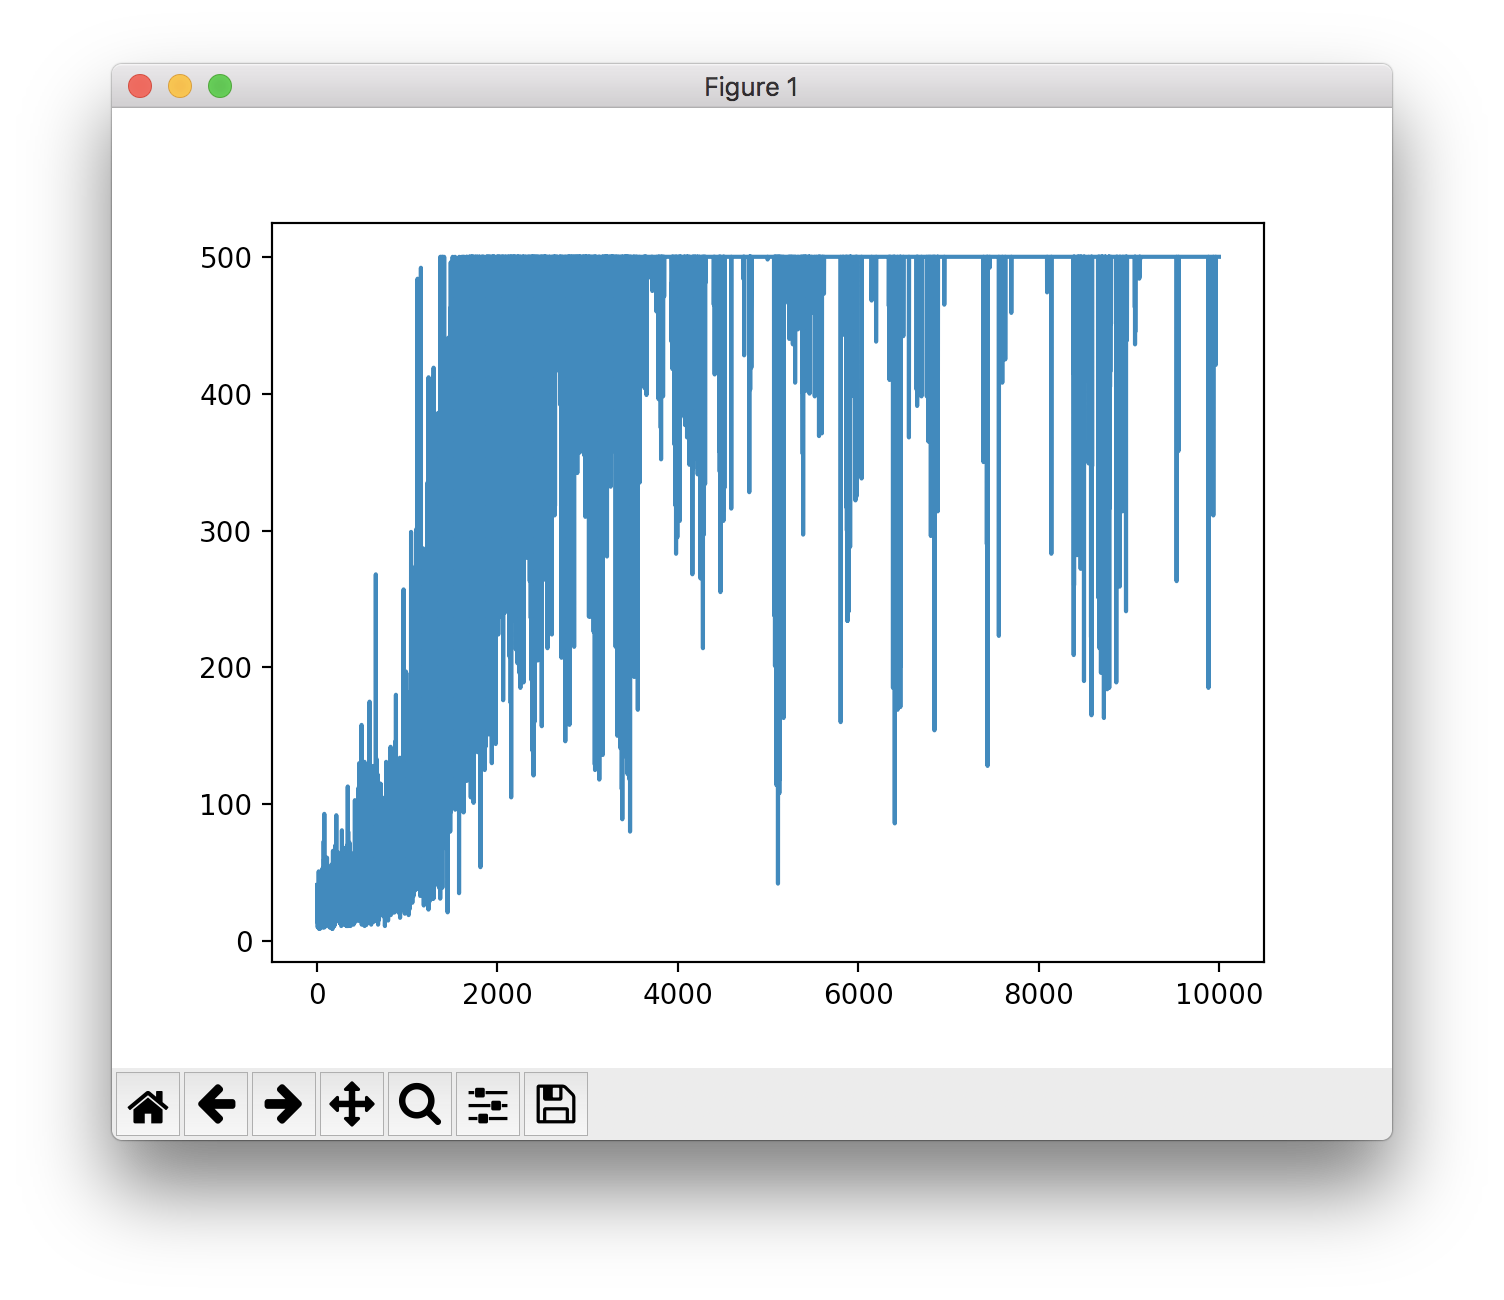

#### First run

In [ ]:
#!/usr/bin/env python3
"""training an agent to play cartpole"""
import numpy as np


def single_episode(env, weight, episode):
    """play one single episode"""
    # reset the environment and get the initial state
    state = env.reset()[None, :]

    # list to store gradients and other info for each step in the episode
    episode_data = []

    while True:
        # get the action and gradient for the current state
        action, grad = policy_gradient(state, weight)

        # take the action in the environment and observe the result
        state, reward, done, _ = env.step(action)
        state = state[None, :]

        # store state, action, reward, and gradient info
        episode_data.append((state, action, reward, grad))

        if done:
            break

    env.close()

    return episode_data

def train(env, nb_episodes, alpha=0.000045, gamma=0.98):
    """
    train the model

    args:
      env: the environment to train in
      nb_episodes: number of episodes to train for
      alpha: learning rate
      gamma: discount factor
    """
    # initialize the weight matrix randomly
    weight = np.random.rand(4, 2)

    # list to store the sum of rewards for each episode
    episode_rewards = []

    for episode in range(nb_episodes):
        # play a single episode and get the data
        episode_data = single_episode(env, weight, episode, show_result)

        # calculate the total number of steps in the episode
        T = len(episode_data) - 1

        sum_rewards = 0
        for t in range(0, T):
            _, _, reward, grad = episode_data[t]

            # accumulate the rewards
            sum_rewards += reward

            # calculate the return G
            G = np.sum([
                gamma**episode_data[k][2] *
                episode_data[k][2] for k in range(t + 1, T + 1)])

            # update the weights using the policy gradient update rule
            weight += alpha * G * grad

        # store the sum of rewards for this episode
        episode_rewards.append(sum_rewards)

        # print the episode number and sum of rewards
        print("{}: {}".format(episode, sum_rewards), end="\r", flush=False)

    return episode_rewards

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


original outcome below... seems like overfitting.

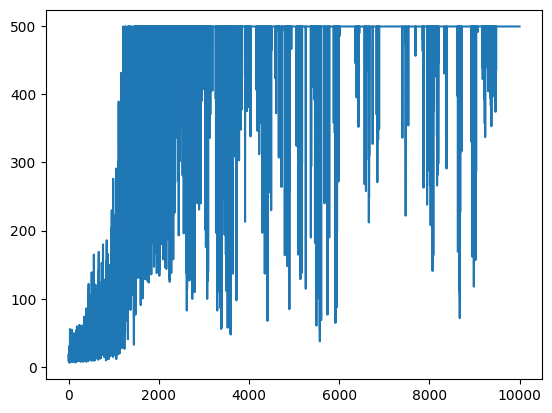

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make('CartPole-v1')

scores = train(env, 10000)

plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

#### Second run: Updated to use Xavier intialization.
Outcome and recordings are in section 3.<br>

In [ ]:
#!/usr/bin/env python3
"""
implements a simple policy gradient reinforcement learning algorithm

It is designed to train an agent in a given environment
  by optimizing its policy through gradient ascent.
The agent learns to maximize cumulative rewards in the environment.

functions:
    single_episode: executes a single episode of interaction
    train: runs the training process over the specified episode count
"""
import numpy as np


def xavier_initialization(input_dim, output_dim):
    """
    initialize weights using Xavier initialization

    Why Xavier Initialization?
      Balanced Initial Weights:
        It provides a balance in the initial weights,
          ensuring that the output of the linear layer before the softmax is not too large or too small,
          which helps in maintaining a healthy gradient flow.
      Facilitates Learning:
        Especially in the early stages of training, it prevents the softmax function from saturating,
          allowing for more effective exploration of the action space.

    args:
        input_dim: size of the input layer (number of input features)
        output_dim: size of the output layer (number of actions)

    returns:
        numpy.ndarray of initialized weights
    """
    limit = np.sqrt(6 / (input_dim + output_dim))
    return np.random.uniform(-limit, limit, (input_dim, output_dim))

def single_episode(env, weight):
    """
    play one single episode in the environment using the policy gradient method

    args:
        env: the environment in which the agent operates
        weight: the current weights of the policy network

    returns:
        a list of tuples containing state, action, reward, and gradient for each step in the episode
    """
    state = env.reset()[None, :]  # reset the environment to start a new episode and get the initial state
    return_grad = []  # initialize a list to store state, action, reward, and gradient at each step

    while True:
        action, grad = policy_gradient(state, weight)  # compute action and gradient for the current state
        state, reward, done, _ = env.step(action)  # take the action in the environment and observe the outcome
        state = state[None, :]
        return_grad.append((state, action, reward, grad))  # store the results of the step

        if done:
            break  # exit the loop if the episode is finished

    return return_grad

def train(env, nb_episodes, alpha=0.000045, gamma=0.98):
    """
    train the agent

    args:
        env: environment in which the agent is trained
        nb_episodes: number of episodes to train the agent
        alpha: learning rate for updating the policy network's weights
        gamma: discount factor for calculating the return (cumulative discounted rewards)

    Returns:
        A list of cumulative rewards obtained in each episode during training
    """
    try:
        # (4, 2) is specific to the structure of the environment and the policy network
        #   for the CartPole environment, the observation space is 4-dimensional (position, velocity, angle, angular velocity),
        #   and the action space is binary (move left or move right), hence the shape (4, 2)
        input_dim = 4  # number of features in the state
        output_dim = 2  # number of possible actions

        weight = xavier_initialization(input_dim, output_dim)
        episodes = []  # list to store the cumulative reward of each episode

        for episode in range(nb_episodes):
            single = single_episode(env, weight)  # run a single episode
            T = len(single)  # total number of steps in the episode

            rewards = np.array([single[t][2] for t in range(T)])  # extract rewards
            gradients = np.array([single[t][3] for t in range(T)])  # extract gradients

            # calculate the return (cumulative discounted reward) for each step
            discounts = np.array([gamma**i for i in range(T)])
            discounted_rewards = rewards * discounts
            cumulative_rewards = np.cumsum(discounted_rewards[::-1])[::-1]

            # update the weights using the policy gradient update rule
            for t in range(T):
                weight += alpha * cumulative_rewards[t] * gradients[t]

            total_reward = np.sum(rewards)
            episodes.append(total_reward)  # store the cumulative reward for this episode
            print(f"Episode {episode}: Total Reward: {total_reward}", end="\r", flush=False)

        return episodes

    except Exception as e:
        print(f"An error occurred during training: {e}")
        return []

below we see a more consistent training pattern methinks.

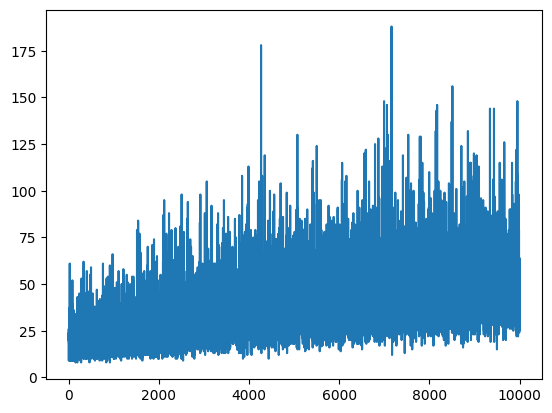

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make('CartPole-v1')

scores = train(env, 10000)

plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

### 3. Animate iteration
TASK:
Update the prototype of the train function by adding a last optional parameter:<br>
```show_result (default: False)```<br>

When this parameter is True, render the environment every 1000 episodes computed.<br>

OUTCOME:<br>
As one cannot render in a Colab environment, episodes were instead recorded along an interval using a gym RecordVideo wrapper.<br>
Videos of the training are then rendered in the environment using a workaround.<br>

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


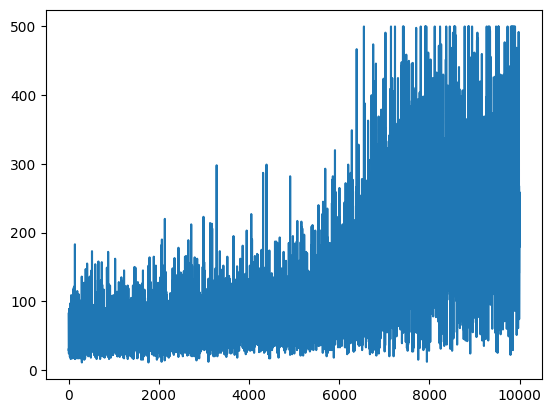

In [ ]:
import gym
from gym.wrappers import RecordVideo
import gym
import matplotlib.pyplot as plt
import numpy as np

totalTrainingSteps = 10000
# rendering every 100 steps (instead of every 1000)
episodeRenderDiv = 100

def make_env():
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    env = RecordVideo(env, video_folder="videos/",
                      episode_trigger=lambda episode_id: episode_id % episodeRenderDiv == 0)
    return env

env = make_env()

scores = train(env, totalTrainingSteps)

plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

In [ ]:
import os
from IPython.display import HTML, display
from base64 import b64encode

def play_video(video_path):
    """
    display a video using mp4 embed with base64 encoding workaround

    args:
        video_path: path to the video file
    """
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

def play_videos_in_sequence(folder_path):
    """
    play all videos in the specified folder
      in sequence according to their episode number

    args:
        folder_path: path to the folder containing video files
    """
    # list all mp4 files in the folder
    files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]

    # sort the files by the episode number extracted from the filename
    sorted_files = sorted(files, key=lambda x: int(x.split('-')[-1].split('.')[0]))

    # display each video
    for file in sorted_files:
        display(play_video(os.path.join(folder_path, file)))

# folder path
video_folder_path = '/content/videos'

play_videos_in_sequence(video_folder_path)

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_path):
    """
    workaround to display a single video in colab

    args:
        video_path: path to the video file
    """
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

video_path = '/content/videos/rl-video-episode-9800.mp4'
play_video(video_path)

### experimental matplotlib render below (not fully working)

In [ ]:
!apt-get install -y imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nan

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_and_save(frames, filename):
    """displays a list of frames as a gif"""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(filename + '.gif', writer='imagemagick', fps=20)
    plt.close()
    return HTML(anim.to_jshtml())

total_step_count = 2000

episodes, all_frames = train(env, total_step_count, 0.000045, 0.98, record=True)

animate_and_save(all_frames[0], f'cartpole{total_step_count}steps')


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_and_save(frames, filename, interval=50, fps=20):
    """creates and saves an animation from a list of frames"""
    fig, ax = plt.subplots()
    ax.axis('off')
    img = ax.imshow(frames[0])

    def animate(i):
        if i < len(frames):
            img.set_data(frames[i])
        return img,

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=interval, blit=True)
    anim.save(f'{filename}.gif', writer='imagemagick', fps=fps)
    plt.close(fig)

    return HTML(anim.to_jshtml())


In [ ]:
import numpy as np

def train(env, nb_episodes, alpha=0.000045, gamma=0.98, record=False, frame_dir="frames", render_interval=1000):
    """training function with frame saving"""
    weight = np.random.rand(4, 2)
    episodes = []
    all_frames = []  # List to store frames

    for episode in range(nb_episodes):
        episode_data = single_episode(env, weight, episode, record, frame_dir, render_interval)
        sum_rewards = 0
        episode_frames = []  # List to store frames for this episode

        for t in range(len(episode_data)):
            state, _, reward, grad = episode_data[t]
            sum_rewards += reward
            G = sum([gamma**k[2] * k[2] for k in episode_data[t + 1:]])
            weight += alpha * G * grad

            # Capture frames at specified intervals
            if record and t % render_interval == 100:
                frame = env.render(mode='rgb_array')
                episode_frames.append(frame)

        episodes.append(sum_rewards)
        all_frames.append(episode_frames)
        print(f"Episode {episode}: Total Reward: {sum_rewards}", end="\r", flush=False)

    return episodes, all_frames


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

total_step_count = 2000

env = gym.make('CartPole-v1', render_mode='rgb_array')

episodes, all_frames = train(env, total_step_count, 0.000045, 0.98, record=True, render_interval=100)

for i, frames in enumerate(all_frames):
    animate_and_save(frames, f'cartpole_animation_episode_{i}')


NameError: name 'single_episode' is not defined